# Unsupervised Learning: Principal Component Analysis

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is an exploratory data analysis tool that uses an orthogonal transformation to turn a set of possibly correlated variables into a set of uncorrelated variables, the so called **principal components**. 

Principal components are simply vectors that are chosen in such a way that (1) each of them maximizes variance and (2) is orthogonal to all preceding principal components. PCA is similar to - and actually based on an - Eigenvector decomposition. 

Intuitively, PCA can be used to rotate the data set in such a way that the principal components align with the axes of the coordinate system, providing a representation of the data that allows insight into what the defining factors of the underlying distribution of the data set are. Since the rotation of the data set is an affine and linear transformation, most properties of the data set are retained.

## A simple example: aligning data

Let's have a look at a simple example in the x-y plane. We generate some random x-y positions drawn from a tilted multivariate Gaussian distribution. We then use PCA to rotate the data set into the principal component frame. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We generate data. The distribution is skewed along one axis and rotated against the x-y plane:

In [2]:
data = np.random.multivariate_normal(mean=(5, 1), cov=np.array([[0.5, 0.45], [0.45, 0.5]]), size=1000)

Text(0, 0.5, 'y')

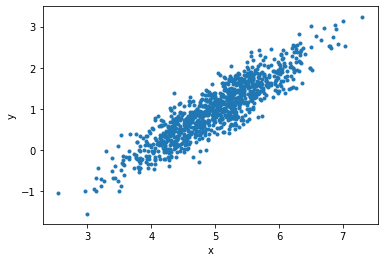

In [3]:
plt.scatter(*data.transpose(), marker='.')
plt.xlabel('x')
plt.ylabel('y')

Before we do anything with the data: keep in mind how important scaling was in the case of clustering. PCA is especially prone to unscaled data as it mainly works with the variance inherent to the data, which in turn is directly impacted by scaling. 

So let's scale the data first using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), which removes the mean from each dimension and scales it to unit variance. Other scaler types are available in [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)

scaled_data = scaler.transform(data)

Text(0, 0.5, 'y')

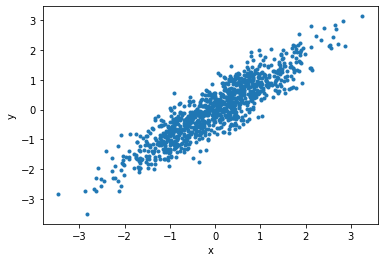

In [5]:
plt.scatter(*scaled_data.transpose(), marker='.')
plt.xlabel('x')
plt.ylabel('y')

The distribution looks exactly the same, but its center is now in the origin and both axes have equal lengths.

We now fit PCA to the data distribution.

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA()
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Now we apply the rotation transformation to the data:

In [8]:
transformed_scaled_data = pca.transform(scaled_data)

Text(0, 0.5, 'PC2')

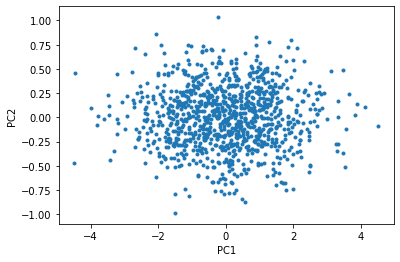

In [9]:
plt.scatter(*transformed_scaled_data.transpose(), marker='.')
plt.xlabel('PC1')
plt.ylabel('PC2')

The data is now transformed in the principal component frame.

## PCA applied to the Iris data set


The Iris data set is a classic ML data set for classification. It holds four different properties of 3 classes of [Iris](https://en.wikipedia.org/wiki/Iris); the properties - or "features" - can be used to differentiate the different classes of Iris plants.

Let's load the data set and look at the description:

In [10]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Here, we are not so much interested in the classification of the data set. Instead, we would like to know which properties provide the most amount of information in the sense of data set variance.

We extract the data set features:

In [11]:
X = iris.data
X.shape

(150, 4)

Again, we apply a StandardScaler before running PCA.

In [12]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

Let's use a corner plot to visualize the data.

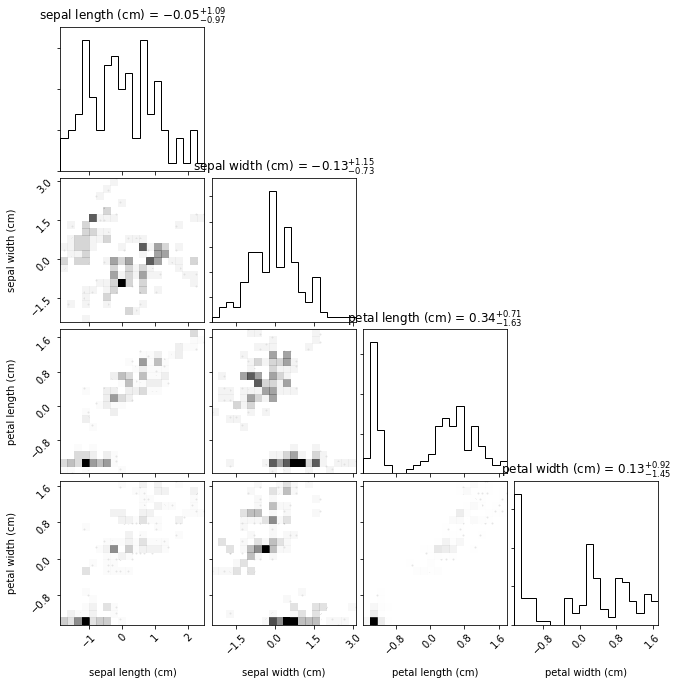

In [13]:
import corner

figure = corner.corner(scaled_X, labels=iris.feature_names,
                       plot_contours=False,
                       show_titles=True, title_kwargs={"fontsize": 12})

Note how the sepal width-sepal length plot shows the widest spread of all combinations; it also seems to show three distinct clusters. Those two variables might be important..

We apply PCA to find out more.

In [14]:
pca = PCA()
transformed_scaled_X = pca.fit_transform(scaled_X)

Note how we used the combined `fit_transform` methods here, which fit the data and transform them in one method call.

## Explaining the variance with PCA
We want to know which of the four parameters provide the most amount of information. scikit-learn provides a tool that tells us the ratio at which each principal component contributes to the measured variance in the data set:

In [15]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

The first principal component explains 72.8%, the second one 23%, and the others barely contribute.

Let's plot the first two principal components and color-encode the data points based on their class.

Text(0, 0.5, 'pc2')

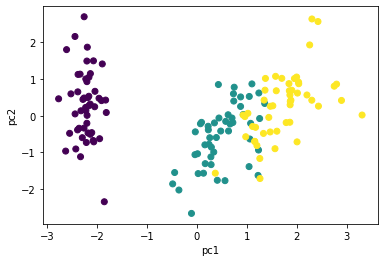

In [16]:
plt.scatter(transformed_scaled_X[:,0], transformed_scaled_X[:, 1], c=iris.target)
plt.xlabel('pc1')
plt.ylabel('pc2')

Note how the first two principal components lead to a good separation of the different classes (keep in mind that PCA uses no information on classes!).

Now we want to know which of the original features are most important. We can use the derived PCA-transformations to project the explained variance ratios on the original feature space.

First, we derive the squares of the transformation's component weights (since we are interested in magnitude, not direction). Then we multiply these squared weights with their relative contributions to the total variance and sum over each feature:

In [18]:
list(zip(iris.feature_names, np.sum(pca.explained_variance_ratio_*(pca.components_**2).transpose(), axis=0)))

[('sepal length (cm)', 0.7296244541329981),
 ('sepal width (cm)', 0.2285076178670179),
 ('petal length (cm)', 0.03668921889282881),
 ('petal width (cm)', 0.005178709107154801)]

- components: the values in the transformation matrix
- multiply ratio by squared components matrix and sum on column
- zip with feature names to make this tuple
- why are the feature and PCA explained variances the same?

As we expected from the corner plot, sepal length and sepal width clearly contribute most to the explained variance. Those are the most important features!

In [19]:
(pca.explained_variance_ratio_*(pca.components_**2))

array([[1.98100107e-01, 1.65777809e-02, 1.23598406e-02, 1.65233398e-03],
       [1.03930667e-01, 1.94797003e-01, 2.20076213e-05, 2.32069846e-05],
       [3.77781839e-01, 1.36470357e-02, 7.41118731e-04, 2.08340454e-03],
       [4.98118410e-02, 3.48579828e-03, 2.35662519e-02, 1.41976361e-03]])